In [1]:
from pathlib import Path # to interact with file system.

import numpy as np # for working with arrays.
import pandas as pd # for working with data frames (tables).

from sklearn import metrics

from sklearn.model_selection import train_test_split, cross_val_score # for data partition.
from sklearn.metrics import r2_score # to identify r_squared for regression model.
from sklearn.linear_model import LinearRegression # for linear regression model.
from sklearn.metrics import mean_squared_error,mean_absolute_error

%matplotlib inline 
import matplotlib.pylab as plt

from dmba import regressionSummary, exhaustive_search
from dmba import backward_elimination, forward_selection, stepwise_selection
from dmba import adjusted_r2_score, AIC_score, BIC_score

from sklearn.metrics import accuracy_score
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
import os
import calendar
#import scatter_matrix, parallel_coordinates
import seaborn as sns
from sklearn import preprocessing

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


In [2]:
pip install dmba

In [3]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [4]:
import seaborn as sns
import matplotlib.pylab as plt

# Read the Data

In [5]:
fact_taxi_df = pd.read_csv("fact_taxi_transport.csv", low_memory=False)
dim_weather_df = pd.read_csv("New_Weather_Data.csv")
time_data_PU_df = pd.read_csv("time_data.csv")
time_data_DO_df = pd.read_csv("time_data.csv")
dim_location_PU_df = pd.read_csv("Dim_location.csv")
dim_location_DO_df = pd.read_csv("Dim_location.csv")
business_data_df = pd.read_csv("business_data.csv")

In [6]:
fact_taxi_df.columns

Index(['Dim_pickup_time_id', 'Dim_Dropoff_time_id', 'Dim_Pickup_Location_id',
       'Dim_Dropoff_Location_id', 'Dim_Business_id', 'Dim_Weather_id',
       'Dim_carpooled_id', 'Dim_PublicTransport', 'Dim_DriveAlone_id',
       'Trip_Distance', 'Tip_amount', 'Total_amount'],
      dtype='object')

# Rename neccessary columns to join data from different files

In [7]:
business_data_df = business_data_df.rename(columns= {'Business_id': 'Dim_Business_id'})
dim_location_PU_df = dim_location_PU_df.rename(columns= {'LocationID' : 'Dim_Pickup_Location_id', 'Borough' : 'PUBorough', 'Zone' : 'PUZone'})
dim_location_DO_df = dim_location_DO_df.rename(columns= {'LocationID' : 'Dim_Dropoff_Location_id', 'Borough' : 'DOBorough', 'Zone' : 'DOZone'})
time_data_PU_df = time_data_PU_df.rename(columns= {'Timestamp' : 'PUTimestamp', 'Time_id' : 'Dim_pickup_time_id'})
time_data_DO_df = time_data_DO_df.rename(columns= {'Timestamp' : 'DOTimestamp', 'Time_id' : 'Dim_Dropoff_time_id'})
dim_weather_df = dim_weather_df.rename(columns= {'Weather_id' : 'Dim_Weather_id' })

In [8]:
weather_df = dim_weather_df.drop(['city_name','Date_Time'], axis = 1)
unique_weather_data = weather_df.drop_duplicates()

# Joining the Data

In [9]:
taxi_df = business_data_df[['Industry', 'Dim_Business_id']].merge(fact_taxi_df[['Dim_pickup_time_id', 'Dim_Dropoff_time_id', 'Dim_Pickup_Location_id','Dim_Dropoff_Location_id', 'Dim_Business_id', 'Dim_Weather_id','Dim_carpooled_id', 'Dim_DriveAlone_id', 'Dim_PublicTransport','Trip_Distance', 'Tip_amount', 'Total_amount']], on = 'Dim_Business_id', how = 'right')
taxi_df = dim_location_PU_df[['Dim_Pickup_Location_id', 'PUBorough', 'PUZone']].merge(taxi_df[['Industry', 'Dim_Business_id', 'Dim_pickup_time_id','Dim_Dropoff_time_id', 'Dim_Pickup_Location_id','Dim_Dropoff_Location_id', 'Dim_Weather_id', 'Dim_carpooled_id','Dim_DriveAlone_id', 'Dim_PublicTransport', 'Trip_Distance','Tip_amount', 'Total_amount']], on = 'Dim_Pickup_Location_id', how = 'right')
taxi_df = dim_location_DO_df[['Dim_Dropoff_Location_id', 'DOBorough', 'DOZone']].merge(taxi_df[['Industry', 'Dim_Business_id', 'Dim_pickup_time_id', 'PUBorough', 'PUZone','Dim_Dropoff_time_id', 'Dim_Pickup_Location_id','Dim_Dropoff_Location_id', 'Dim_Weather_id', 'Dim_carpooled_id','Dim_DriveAlone_id', 'Dim_PublicTransport', 'Trip_Distance','Tip_amount', 'Total_amount']], on = 'Dim_Dropoff_Location_id', how = 'right')
taxi_df = time_data_PU_df[['PUTimestamp', 'Dim_pickup_time_id']].merge(taxi_df[['Dim_Dropoff_Location_id', 'DOBorough', 'DOZone', 'Industry','Dim_Business_id', 'Dim_pickup_time_id', 'PUBorough', 'PUZone','Dim_Dropoff_time_id', 'Dim_Pickup_Location_id', 'Dim_Weather_id','Dim_carpooled_id', 'Dim_DriveAlone_id', 'Dim_PublicTransport','Trip_Distance', 'Tip_amount', 'Total_amount']], on = 'Dim_pickup_time_id', how = 'right')
taxi_df = time_data_DO_df[['DOTimestamp', 'Dim_Dropoff_time_id']].merge(taxi_df[['Dim_Dropoff_Location_id', 'DOBorough', 'DOZone', 'Industry','Dim_Business_id', 'Dim_pickup_time_id','PUTimestamp', 'PUBorough', 'PUZone','Dim_Dropoff_time_id', 'Dim_Pickup_Location_id', 'Dim_Weather_id','Dim_carpooled_id', 'Dim_DriveAlone_id', 'Dim_PublicTransport','Trip_Distance', 'Tip_amount', 'Total_amount']], on = 'Dim_Dropoff_time_id', how = 'right')
taxi_df = unique_weather_data[['Dim_Weather_id', 'weather_type', 'Temperature']].merge(taxi_df[['Dim_Dropoff_Location_id', 'DOBorough', 'DOZone', 'Industry','Dim_Business_id', 'Dim_pickup_time_id','PUTimestamp', 'PUBorough', 'PUZone','Dim_Dropoff_time_id','DOTimestamp', 'Dim_Pickup_Location_id', 'Dim_Weather_id','Dim_carpooled_id', 'Dim_DriveAlone_id', 'Dim_PublicTransport','Trip_Distance', 'Tip_amount', 'Total_amount']], on = 'Dim_Weather_id', how = 'right')

In [10]:
taxi_df.columns

Index(['Dim_Weather_id', 'weather_type', 'Temperature',
       'Dim_Dropoff_Location_id', 'DOBorough', 'DOZone', 'Industry',
       'Dim_Business_id', 'Dim_pickup_time_id', 'PUTimestamp', 'PUBorough',
       'PUZone', 'Dim_Dropoff_time_id', 'DOTimestamp',
       'Dim_Pickup_Location_id', 'Dim_carpooled_id', 'Dim_DriveAlone_id',
       'Dim_PublicTransport', 'Trip_Distance', 'Tip_amount', 'Total_amount'],
      dtype='object')

In [11]:
taxi_df.dtypes

Dim_Weather_id              object
weather_type                object
Temperature                 object
Dim_Dropoff_Location_id      int64
DOBorough                   object
DOZone                      object
Industry                    object
Dim_Business_id             object
Dim_pickup_time_id          object
PUTimestamp                 object
PUBorough                   object
PUZone                      object
Dim_Dropoff_time_id         object
DOTimestamp                 object
Dim_Pickup_Location_id       int64
Dim_carpooled_id            object
Dim_DriveAlone_id           object
Dim_PublicTransport         object
Trip_Distance              float64
Tip_amount                 float64
Total_amount               float64
dtype: object

# Dropping unneccessary columns like ID's

In [12]:
taxi_df = taxi_df.drop([ 'Dim_carpooled_id','Dim_Weather_id','Dim_Dropoff_Location_id','Dim_Business_id', 'Dim_pickup_time_id','Dim_Dropoff_time_id','Dim_Pickup_Location_id', 'Dim_DriveAlone_id','Dim_PublicTransport','DOBorough','PUBorough'],axis=1)

# Converting the data types as appropriate

In [13]:
taxi_df['DOTimestamp'] = pd.to_datetime(taxi_df['DOTimestamp'], format='%d-%m-%Y %H:%M')
taxi_df['PUTimestamp'] = pd.to_datetime(taxi_df['PUTimestamp'], format='%d-%m-%Y %H:%M')
taxi_df.DOZone = taxi_df.DOZone.astype('category')
taxi_df.PUZone = taxi_df.PUZone.astype('category')
taxi_df.weather_type = taxi_df.weather_type.astype('category')
taxi_df.Temperature = taxi_df.Temperature.astype('category')
taxi_df.Industry = taxi_df.Industry.astype('category')

# Convert Timestamp to month, weekday, hour

In [14]:
taxi_df['PU_weekday'] = taxi_df.PUTimestamp.dt.day_name
taxi_df['PU_month'] = taxi_df.PUTimestamp.dt.month
taxi_df['PU_weekday_num'] = ((taxi_df.PUTimestamp.dt.weekday +1)%7)+1
taxi_df['PU_pickup_hour'] = taxi_df.PUTimestamp.dt.hour
taxi_df['DO_weekday'] = taxi_df.DOTimestamp.dt.day_name
taxi_df['DO_month'] = taxi_df.DOTimestamp.dt.month
taxi_df['DO_weekday_num'] = ((taxi_df.DOTimestamp.dt.weekday +1)%7)+1
taxi_df['DO_pickup_hour'] = taxi_df.DOTimestamp.dt.hour

In [15]:
taxi_df.PU_weekday_num = taxi_df.PU_weekday_num.astype('category')
taxi_df.DO_weekday_num = taxi_df.DO_weekday_num.astype('category')

In [16]:
taxi_df.columns

Index(['weather_type', 'Temperature', 'DOZone', 'Industry', 'PUTimestamp',
       'PUZone', 'DOTimestamp', 'Trip_Distance', 'Tip_amount', 'Total_amount',
       'PU_weekday', 'PU_month', 'PU_weekday_num', 'PU_pickup_hour',
       'DO_weekday', 'DO_month', 'DO_weekday_num', 'DO_pickup_hour'],
      dtype='object')

# Correlation Matrix

In [17]:
numeric_columns = ['Trip_Distance', 'Tip_amount', 'Total_amount']
numeric_data = taxi_df[numeric_columns]

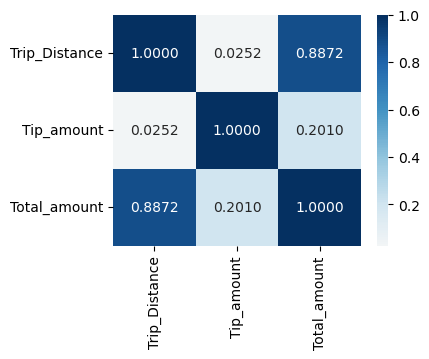

In [18]:
corr = numeric_data.corr()
fig, ax = plt.subplots()
fig.set_size_inches(4, 3)
sns.heatmap(corr, annot=True, fmt=".4f", cmap="RdBu", center=0, ax=ax)
plt.show()

In [19]:
taxi_df.tail(5)

,weather_type,Temperature,DOZone,Industry,PUTimestamp,PUZone,DOTimestamp,Trip_Distance,Tip_amount,Total_amount,PU_weekday,PU_month,PU_weekday_num,PU_pickup_hour,DO_weekday,DO_month,DO_weekday_num,DO_pickup_hour
5503,light rain,291-311,Central Harlem,Third Party Food Delivery,2023-03-07 22:00:00,East Harlem South,2023-03-07 22:03:00,0.83,0.0,8.3,<bound method PandasDelegate._add_delegate_acc...,3,3,22,<bound method PandasDelegate._add_delegate_acc...,3,3,22
5504,light rain,291-311,Central Harlem,Electronic Cigarette Dealer,2023-03-07 22:00:00,East Harlem South,2023-03-07 22:03:00,0.83,0.0,8.3,<bound method PandasDelegate._add_delegate_acc...,3,3,22,<bound method PandasDelegate._add_delegate_acc...,3,3,22
5505,light rain,291-311,Central Harlem,Tobacco Retail Dealer,2023-03-07 22:00:00,East Harlem South,2023-03-07 22:03:00,0.83,0.0,8.3,<bound method PandasDelegate._add_delegate_acc...,3,3,22,<bound method PandasDelegate._add_delegate_acc...,3,3,22
5506,light rain,291-311,Central Harlem,Garage,2023-03-07 22:00:00,East Harlem South,2023-03-07 22:03:00,0.83,0.0,8.3,<bound method PandasDelegate._add_delegate_acc...,3,3,22,<bound method PandasDelegate._add_delegate_acc...,3,3,22
5507,light rain,291-311,Central Harlem,Secondhand Dealer - General,2023-03-07 22:00:00,East Harlem South,2023-03-07 22:03:00,0.83,0.0,8.3,<bound method PandasDelegate._add_delegate_acc...,3,3,22,<bound method PandasDelegate._add_delegate_acc...,3,3,22


In [20]:
taxi_df.columns

Index(['weather_type', 'Temperature', 'DOZone', 'Industry', 'PUTimestamp',
       'PUZone', 'DOTimestamp', 'Trip_Distance', 'Tip_amount', 'Total_amount',
       'PU_weekday', 'PU_month', 'PU_weekday_num', 'PU_pickup_hour',
       'DO_weekday', 'DO_month', 'DO_weekday_num', 'DO_pickup_hour'],
      dtype='object')

# Scaling the Data

In [21]:
scaler = preprocessing.StandardScaler()
scaler.fit(taxi_df[['Trip_Distance']])  # Note the use of an array of column names

# Transform the full dataset
taxiNorm = pd.concat([pd.DataFrame(scaler.transform(taxi_df[['Trip_Distance']]), 
                                    columns=['zTrip_Distance']),
                       taxi_df[['weather_type', 'Temperature', 'DOZone','PUZone', 'Total_amount','Tip_amount','PU_weekday_num', 'PU_pickup_hour','DO_weekday_num', 'DO_pickup_hour']]], axis=1)


# Choosing the Target Variable and Splitting the Data into Test and Train

In [22]:
predictors = ['zTrip_Distance', 'weather_type', 'Temperature', 'DOZone','PUZone','PU_weekday_num', 'PU_pickup_hour','DO_weekday_num', 'DO_pickup_hour']
outcome = 'Tip_amount'


# partition data
X = pd.get_dummies(taxiNorm[predictors], drop_first=True)
y = taxiNorm[outcome]
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.3, random_state=100)

# Linear Regression Model

In [23]:
taxi_lm = LinearRegression()
taxi_lm.fit(train_X, train_y)

# print coefficients
print('intercept ', taxi_lm.intercept_)
print(pd.DataFrame({'Predictor': X.columns, 'coefficient': taxi_lm.coef_}))

# print performance measures
regressionSummary(train_y, taxi_lm.predict(train_X))

intercept  4.627801461423881
                   Predictor   coefficient
0             zTrip_Distance  1.005767e+00
1             PU_pickup_hour -3.140394e+10
2             DO_pickup_hour  3.140394e+10
3    weather_type_few clouds  1.136840e+00
4           weather_type_fog  9.465912e-01
..                       ...           ...
185         DO_weekday_num_3 -4.105835e-01
186         DO_weekday_num_4  2.023125e-02
187         DO_weekday_num_5  3.670802e+08
188         DO_weekday_num_6  6.972703e+10
189         DO_weekday_num_7 -3.140394e+10

[190 rows x 2 columns]

Regression statistics

               Mean Error (ME) : 0.0002
Root Mean Squared Error (RMSE) : 1.3198
     Mean Absolute Error (MAE) : 0.8681


Measure the error metrics

In [34]:
pred_y = taxi_lm.predict(train_X)


print('adjusted r2 : ', adjusted_r2_score(train_y, pred_y, taxi_lm))
print('AIC : ', AIC_score(train_y, pred_y, taxi_lm))
print('BIC : ', BIC_score(train_y, pred_y, taxi_lm))

adjusted r2 :  0.5853209459753438
AIC :  13463.117771121137
BIC :  14664.486018032643


In [35]:
# Use predict() to make predictions on a new set
taxi_lm_pred = taxi_lm.predict(valid_X)

result = pd.DataFrame({'Predicted': taxi_lm_pred, 'Actual': valid_y,
                       'Residual': valid_y - taxi_lm_pred})
print(result.head(20))

# Compute common accuracy measures
regressionSummary(valid_y, taxi_lm_pred)

      Predicted  Actual  Residual
5441   3.639682    3.64  0.000318
1244   0.353315    0.00 -0.353315
3648   0.244768    0.00 -0.244768
2982   1.219827    3.00  1.780173
709    1.366665    2.80  1.433335
42     1.235492    1.85  0.614508
339   -0.000228    0.00  0.000228
1366   1.229313    0.00 -1.229313
3662   3.778551    0.00 -3.778551
5442   3.639682    3.64  0.000318
664    2.959395    4.39  1.430605
2389   0.688226    0.90  0.211774
5052  -0.432560    2.00  2.432560
5454   3.639682    3.64  0.000318
3854   2.101457    2.30  0.198543
3049   2.205942    2.44  0.234058
634    0.805315    0.00 -0.805315
1054   3.165966    3.64  0.474034
3629   3.171899    3.00 -0.171899
585    3.629878    4.58  0.950122

Regression statistics

               Mean Error (ME) : 0.0509
Root Mean Squared Error (RMSE) : 1.3823
     Mean Absolute Error (MAE) : 0.9020


In [39]:
print('r2 : ', r2_score(valid_y, taxi_lm_pred))
print('adjusted r2 : ', adjusted_r2_score(valid_y, taxi_lm_pred, taxi_lm))
print('AIC : ', AIC_score(valid_y, taxi_lm_pred, taxi_lm))
print('BIC : ', BIC_score(valid_y, taxi_lm_pred, taxi_lm))

r2 :  0.545388929727596
adjusted r2 :  0.48630814768125075
AIC :  6145.312973137317
BIC :  7184.099615918954


1.0


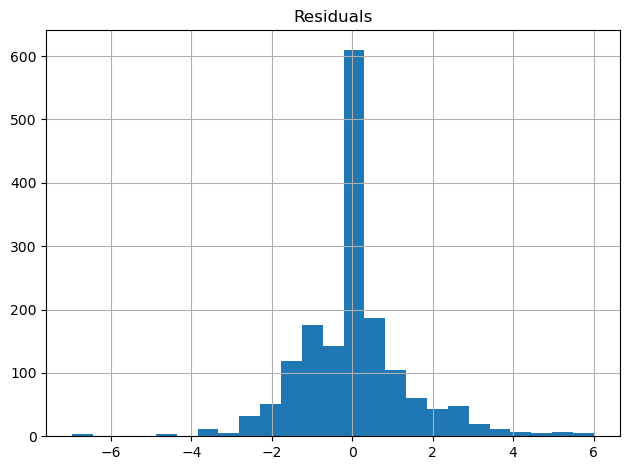

In [36]:
taxi_lm_pred = taxi_lm.predict(valid_X)
all_residuals = valid_y - taxi_lm_pred

# Determine the percentage of datapoints with a residual in [-1406, 1406] = approx. 75\%
print(len(all_residuals[(all_residuals > -1406) & (all_residuals < 1406)]) / len(all_residuals))

ax = pd.DataFrame({'Residuals': all_residuals}).hist(bins=25)

plt.tight_layout()
plt.show()

# XGBoost Model

In [27]:
import xgboost as xgb

In [28]:
# XGBoost regression model 
xgb_reg = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1)

# Train 
xgb_reg.fit(train_X, train_y)  

# Predict  
y_pred = xgb_reg.predict(valid_X)

In [40]:
# Compute common accuracy measures
regressionSummary(valid_y, y_pred)


Regression statistics

               Mean Error (ME) : 0.0368
Root Mean Squared Error (RMSE) : 0.7826
     Mean Absolute Error (MAE) : 0.5968


Measure the Error Metrics

In [29]:
# Evaluate RMSE
from sklearn.metrics import mean_squared_error 
rmse = np.sqrt(mean_squared_error(valid_y, y_pred))
print("RMSE: %f" % rmse)

r2 = r2_score(valid_y, y_pred) 


print("R^2:", r2)

RMSE: 0.782562
R^2: 0.8542946805197011
